$dv_i/dt = - \sum_{j \neq i} G M_j / {r_{ij}}^3 (\bf{r}_i - \bf{r}_j)$ where $r_{ij} = |\bf{r}_i - \bf{r}_j| = [(x_i - x_j)^2 + (y_i - y_j)^2]^{1/2}$  <br>
$\bf{r}'_i = \bf{r}_i + \bf{v}_i \Delta t$ <br>
$dv_i/dt = - \sum_{j \neq i} G M_j / {r'_{ij}}^3 (\bf{r}'_i - \bf{r}'_j)$ <br>
$\bf{v}'_i = \bf{v}_i + d\bf{v}_i/dt \Delta t$ <br>

In [3]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.style.use('./accretion.mplstyle')
import numpy as np
from astropy import constants as const
from astropy import units as u
from collections import OrderedDict

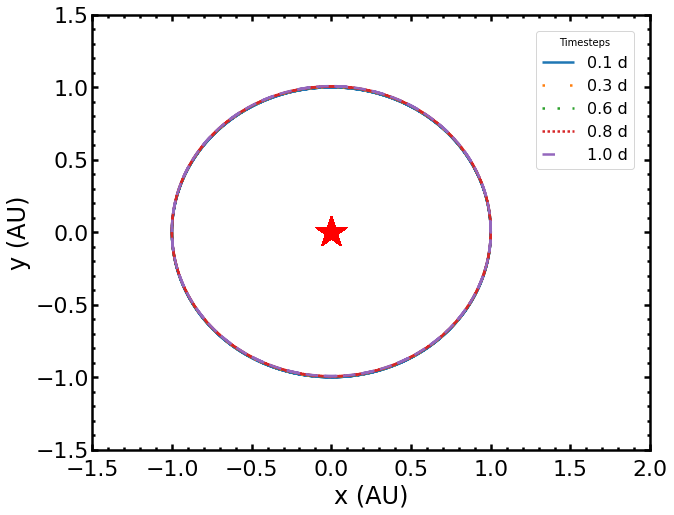

In [15]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt = -(G * M_j / r_ij**3 * ((r_i[0].value - r_j[0].value,r_i[1].value-r_j[1].value)*u.cm)).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    x_j=r_j[0]
    y_j=r_j[1]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2)
    return r_ij

def finp(v,dt,x):
    return v*dt+x

def finv(v,dvdt,dt):
    return v+dvdt*dt

def KE(mass,v_i):
    v_r = np.sqrt(v_i[0]**2+v_i[1]**2)
    return 0.5*mass*(v_r**2)

def PE(m1,m2,r_ij):
    G = const.G.cgs
    return -G*m1*m2/r_ij

def AngMom(mass,r_i,v_i):
    rxv = r_i[0]*v_i[1]-r_i[1]*v_i[0]
    return mass*rxv

linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

delta_ts = [0.1,0.3,0.6,0.8,1]*u.day

G = const.G.cgs
a = const.au.to(u.cm)
m_e = const.M_earth.to(u.g)
m_s = const.M_sun.to(u.g)

delta_Es = [0]*len(delta_ts)
delta_Ls = [0]*len(delta_ts)
t_ranges = [0]*len(delta_ts)

orbits=3

fig=plt.figure(figsize=(10,8))
for n,delta_t in enumerate(delta_ts):
    t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
    # Initialize position and velocity arrays
    r_i = [(0,0)]*len(t_range)
    r_j = [(0,0)]*len(t_range)
    x_i = [(0,0)]*len(t_range)
    x_j = [(0,0)]*len(t_range)
    y_i = [(0,0)]*len(t_range)
    y_j = [(0,0)]*len(t_range)
    v_i = [(0,0)]*len(t_range)
    v_j = [(0,0)]*len(t_range)

    steps=len(t_range)                                  # The number of steps in the time array
    # Set initial position for Earth and Sun
    r_i[0] = (a,0*u.cm)
    r_j[0] = ((-a*m_e/m_s).to(u.cm),0*u.cm)
    x_i[0] = r_i[0][0]
    y_i[0] = r_i[0][1]
    x_j[0] = r_j[0][0]
    y_j[0] = r_j[0][1]
    # Set initial velocities for Earth and Sun
    v_i[0] = (0*u.cm/u.day,np.sqrt(G*m_s/(a+x_j[0])).to(u.cm/u.day))
    v_j[0] = ((0*u.cm/u.day,-np.sqrt(G*m_s/(a+x_j[0])).to(u.cm/u.day)*m_e/m_s))
    # Initialize empty arrays for change in KE and L
    delta_KE = [(0,0)]*(len(t_range)-1)
    delta_PE = [(0,0)]*(len(t_range)-1)
    delta_E = [(0,0)]*(len(t_range)-1)
    delta_L = [(0,0)]*(len(t_range)-1)

    for t in range(steps-1): # indexing each timestep as t
        # Get radius magnitudes from x,y coordinates
        r_ij = rmag(r_i[t],r_j[t])
        r_ji = rmag(r_j[t],r_i[t])
        # Get the delta v
        dv_i_dt = dvidt(m_s,r_ij,r_i[t],r_j[t])
        dv_j_dt = dvidt(m_e,r_ji,r_j[t],r_i[t])
        # Update the radial position arrays: r' = r + v * dt
        r_i[t+1] = (r_i[t][0] + v_i[t][0]*delta_t,r_i[t][1] + v_i[t][1]*delta_t)
        r_j[t+1] = (r_j[t][0] + v_j[t][0]*delta_t,r_j[t][1] + v_j[t][1]*delta_t)
        # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
        x_i[t+1] = r_i[t+1][0]
        y_i[t+1] = r_i[t+1][1]
        x_j[t+1] = r_j[t+1][0]
        y_j[t+1] = r_j[t+1][1]
        # Update the delta v
        r_ij = rmag(r_i[t+1],r_j[t+1])
        r_ji = rmag(r_j[t+1],r_i[t+1])
        dv_i_dt = dvidt(m_s,r_ij,r_i[t+1],r_j[t+1])
        dv_j_dt = dvidt(m_e,r_ji,r_j[t+1],r_i[t+1])
        # Update the velocity arrays: v' = v + dv/dt * dt
        v_i[t+1] = (v_i[t][0] + dv_i_dt[0] * delta_t,v_i[t][1] + dv_i_dt[1] * delta_t)
        v_j[t+1] = (v_j[t][0] + dv_j_dt[0] * delta_t,v_j[t][1] + dv_j_dt[1] * delta_t)
        # Track change in kinetic energy
        # delta_KE[t] = KE(m_e, v_i[t+1]) - KE(m_e, v_i[t])
        # delta_PE[t] = PE(m_s, m_e, rmag(r_i[t+1],r_j[t+1])) - PE(m_s, m_e, rmag(r_i[t],r_j[t]))
        initial_E = KE(m_e, v_i[t]).cgs + PE(m_s, m_e, rmag(r_i[t],r_j[t])).cgs
        final_E = KE(m_e, v_i[t+1]).cgs + PE(m_s, m_e, rmag(r_i[t+1],r_j[t+1])).cgs
        # delta_E[t] = delta_KE[t]+delta_PE[t]
        delta_E[t] = final_E/initial_E - 1
        # Track change in angular momentum
        initial_L = AngMom(m_e,r_i[t],v_i[t]).cgs
        final_L = AngMom(m_e,r_i[t+1],v_i[t+1]).cgs
        delta_L[t] = (final_L - initial_L)/initial_L
    # Save the delta_KE, delta_L and timescale for future plotting.
    # delta_Es[n] = [E.cgs for E in delta_E]
    delta_Es[n] = delta_E
    delta_Ls[n] = delta_L
    t_ranges[n] = t_range[1:]
    # Plot the coordinates for the Earth and the Sun over time.
    x_i = [(x/a).value for x in x_i]
    y_i = [(y/a).value for y in y_i]
    x_j = [(x/a).value for x in x_j]
    y_j = [(y/a).value for y in y_j]
    line=next(linecycler)
    plt.plot(x_i,y_i,linestyle=line,label=f'{delta_t}')
plt.ylabel('y (AU)')
plt.xlabel('x (AU)')
plt.legend(title=f'Timesteps')
plt.xlim(-1.5,2)
plt.ylim(-1.5,1.5)
plt.scatter(x_j,y_j,marker="*",s=1000,color='red')#,label=f'Sun')
plt.show()

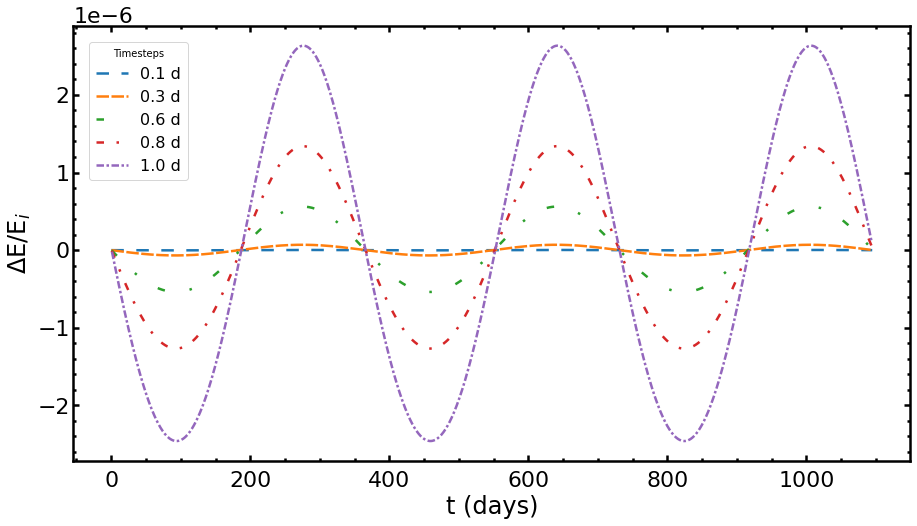

In [16]:
for i,delta_E in enumerate(delta_Es):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    # delta_E = [k.value for k in delta_E]
    line=next(linecycler)
    plt.plot(t_range,delta_E,linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$E/E$_i$')
# plt.yscale('log')
plt.show()

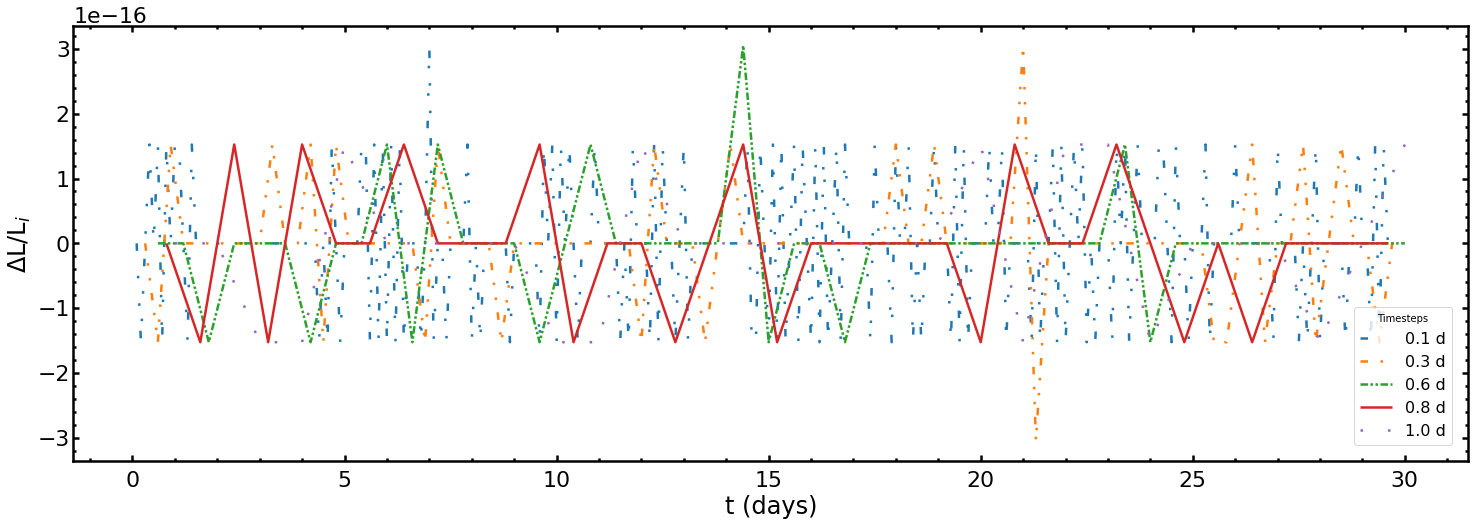

In [17]:
fig=plt.figure(figsize=(25,8))
for i,delta_L in enumerate(delta_Ls):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    # delta_L = [l.value for l in delta_L]
    line=next(linecycler)
    end=int(30/delta_ts[i].value)
    # end=len(delta_L)
    plt.plot(t_range[:end],delta_L[:end],linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$L/L$_i$')
# plt.yscale('log')
plt.show()

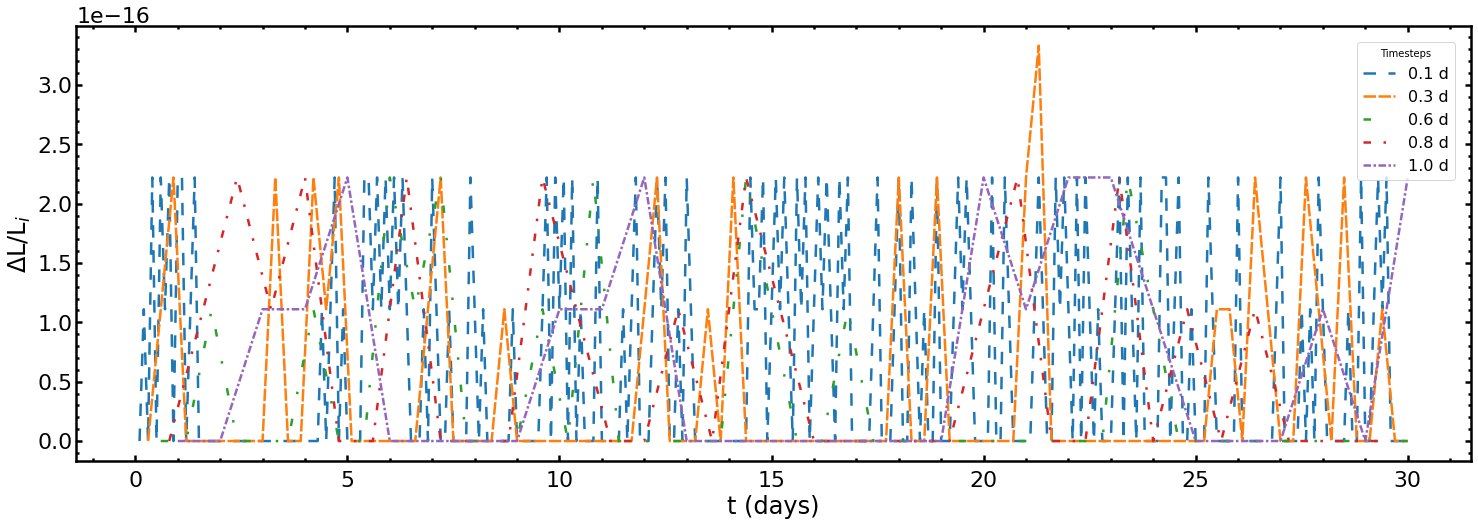

In [11]:
fig=plt.figure(figsize=(25,8))
for i,delta_L in enumerate(delta_Ls):
    t_range = t_ranges[i]
    t_range = [t.value for t in t_range]
    delta_L = [abs(l) for l in delta_L]
    line=next(linecycler)
    end=int(30/delta_ts[i].value)
    # end=len(delta_L)
    plt.plot(t_range[:end],delta_L[:end],linestyle=line,label=f'{delta_ts[i]}')
plt.legend(title=f'Timesteps')
plt.xlabel('t (days)')
plt.ylabel(r'$\Delta$L/L$_i$')
# plt.yscale('log')
plt.show()

# Now Include Venus

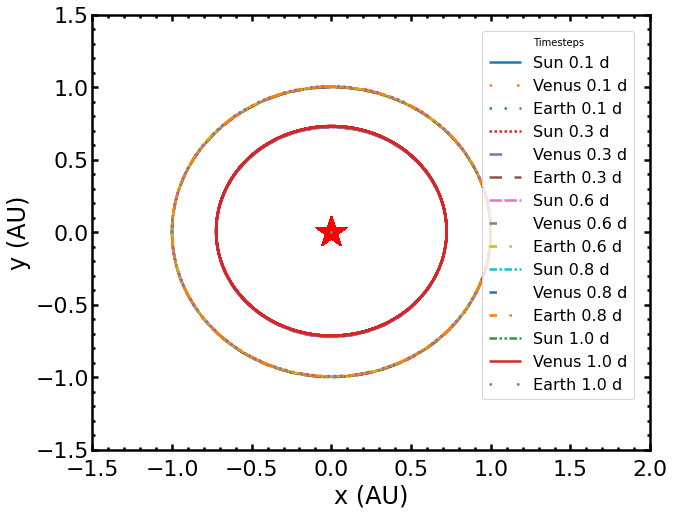

In [12]:
def dvidt(M_j,r_ij,r_i,r_j):
    G = const.G.cgs
    dvdt = -(G * M_j / r_ij**3 * ((r_i[0].value - r_j[0].value,r_i[1].value-r_j[1].value)*u.cm)).to(u.cm/u.day**2)
    return dvdt

def rmag(r_i,r_j):
    x_i=r_i[0]
    y_i=r_i[1]
    x_j=r_j[0]
    y_j=r_j[1]
    r_ij = np.sqrt((x_i-x_j)**2+(y_i-y_j)**2)
    return r_ij

def finp(v,dt,x):
    return v*dt+x

def finv(v,dvdt,dt):
    return v+dvdt*dt

def KE(mass,v_i):
    v_r = np.sqrt(v_i[0]**2+v_i[1]**2)
    return 0.5*mass*(v_r**2)

def PE(m1,m2,r_ij):
    G = const.G.cgs
    return -G*m1*m2/r_ij

def AngMom(mass,r_i,v_i):
    rxv = r_i[0]*v_i[1]-r_i[1]*v_i[0]
    return mass*rxv

linecycler = cycle([(0,()), # solid 
                     (0, (1, 10)), # loosely dotted
                     (0, (1, 5)), # dotted
                     (0, (1, 1)), # densely dotted
                     (0, (5, 10)), # loosely dashed
                     (0, (5, 5)), # dashed
                     (0, (5, 1)), # densely dashed
                     (0, (3, 10, 1, 10)), # loosely dashdotted
                     (0, (3, 5, 1, 5)), # dashdotted
                     (0, (3, 1, 1, 1)), # densely dashdotted
                     (0, (3, 10, 1, 10, 1, 10)), # loosely dashdotdotted
                     (0, (3, 5, 1, 5, 1, 5)), # dashdotdotted
                     (0, (3, 1, 1, 1, 1, 1))]) # densely dashdotdotted

delta_ts = [0.1,0.3,0.6,0.8,1]*u.day

bodies = OrderedDict((("Sun",0),("Venus",1),("Earth",2)))

G = const.G.cgs
a_e = const.au.to(u.cm)
a_v = 0.723*const.au.to(u.cm)
a = OrderedDict(((2,a_e),(1,a_v)))
m_e = const.M_earth.to(u.g)
m_v = (4.8673*10**27)*u.g
m_s = const.M_sun.to(u.g)
m = OrderedDict(((2,m_e),(1,m_v),(0,m_s)))

delta_Es = [0]*len(delta_ts)
delta_Ls = [0]*len(delta_ts)
t_ranges = [0]*len(delta_ts)

orbits = 3

fig=plt.figure(figsize=(10,8))
for n,delta_t in enumerate(delta_ts):
    t_range = np.arange(0,orbits*365,delta_t.value)*u.day      # 1 year timescale in steps of delta_t
    # Initialize position and velocity arrays
    r = [[(0,0)]*len(t_range) for i in range(len(bodies))]
    x = [[(0,0)]*len(t_range) for i in range(len(bodies))]
    y = [[(0,0)]*len(t_range) for i in range(len(bodies))]
    v = [[(0,0)]*len(t_range) for i in range(len(bodies))]

    steps=len(t_range)                                  # The number of steps in the time array
    # Set initial position for Earth and Sun
    r[bodies["Earth"]][0] = (a[bodies["Earth"]],0*u.cm)
    r[bodies["Venus"]][0] = (a[bodies["Venus"]],0*u.cm)
    r[bodies["Sun"]][0] = ((-a[bodies["Earth"]]*(m[bodies["Earth"]]+m[bodies["Venus"]])/m[bodies["Sun"]]).to(u.cm),0*u.cm)
    x[bodies["Earth"]][0] = r[bodies["Earth"]][0][0]
    y[bodies["Earth"]][0] = r[bodies["Earth"]][0][1]
    x[bodies["Venus"]][0] = r[bodies["Venus"]][0][0]
    y[bodies["Venus"]][0] = r[bodies["Venus"]][0][1]
    x[bodies["Sun"]][0] = r[bodies["Sun"]][0][0]
    y[bodies["Sun"]][0] = r[bodies["Sun"]][0][1]
    # Set initial velocities for Earth and Sun
    v[bodies["Earth"]][0] = (0*u.cm/u.day,(29.78*u.km/u.s).to(u.cm/u.day))
    v[bodies["Venus"]][0] = (0*u.cm/u.day,v[bodies["Earth"]][0][1]*1.176)
    v[bodies["Sun"]][0] = ((0*u.cm/u.day,-np.sqrt(G*(sum([m[i] for i in range(len(bodies))]))/(a[bodies["Earth"]]+x[bodies["Sun"]][0])).to(u.cm/u.day)*m[bodies["Earth"]]/sum([m[i] for i in range(len(bodies))])))
    # Initialize empty arrays for change in KE and L
    delta_KE = [[(0,0)]*(len(t_range)-1) for i in range(len(bodies))]
    delta_PE = [[(0,0)]*(len(t_range)-1) for i in range(len(bodies))]
    delta_E = [[(0,0)]*(len(t_range)-1) for i in range(len(bodies))]
    delta_L = [[(0,0)]*(len(t_range)-1) for i in range(len(bodies))]

    for t in range(steps-1): # indexing each timestep as t
        # Get radius magnitudes from x,y coordinates
        for i, body in enumerate(bodies):
            for j, body in enumerate(bodies):
                if i==j:
                    continue
                if i==1 and j==2:
                    continue
                if i==2 and j==1:
                    continue
                # # Get the delta v
                # r_ij = rmag(r[i][t],r[j][t])
                # r_ji = rmag(r[j][t],r[i][t])
                # dv_i_dt = dvidt(m[j],r_ij,r[i][t],r[j][t])
                # dv_j_dt = dvidt(m[i],r_ji,r[j][t],r[i][t])
                # Update the radial position arrays: r' = r + v * dt
                r[i][t+1] = (r[i][t][0] + v[i][t][0]*delta_t,r[i][t][1] + v[i][t][1]*delta_t)
                r[j][t+1] = (r[j][t][0] + v[j][t][0]*delta_t,r[j][t][1] + v[j][t][1]*delta_t)
                # Add the new position to each coordinate array: x_final = v*delta_t + x_initial
                x[i][t+1] = r[i][t+1][0]
                y[i][t+1] = r[i][t+1][1]
                # x[j][t+1] = r[j][t+1][0]
                # y[j][t+1] = r[j][t+1][1]
                # Update the delta v
                r_ij = rmag(r[i][t+1],r[j][t+1])
                # r_ji = rmag(r[j][t+1],r[i][t+1])
                dv_i_dt = dvidt(m[j],r_ij,r[i][t+1],r[j][t+1])
                # dv_j_dt = dvidt(m[i],r_ji,r[j][t+1],r[i][t+1])
                # Update the velocity arrays: v' = v + dv/dt * dt
                v[i][t+1] = (v[i][t][0] + dv_i_dt[0] * delta_t,v[i][t][1] + dv_i_dt[1] * delta_t)
                # v[j][t+1] = (v[j][t][0] + dv_i_dt[0] * delta_t,v[j][t][1] + dv_i_dt[1] * delta_t)
                # Track change in energy
                # delta_KE[i][t] = KE(m[i], v[i][t+1]).cgs - KE(m[i], v[i][t]).cgs
                # delta_PE[i][t] = PE(m[i],m[j],rmag(r[i][t+1],r[j][t+1])).cgs - PE(m[i],m[j],rmag(r[i][t],r[j][t])).cgs
                initial_E = KE(m[i], v[i][t]).cgs + PE(m[i], m[j], rmag(r[i][t],r[j][t])).cgs
                final_E = KE(m[i], v[i][t+1]).cgs + PE(m[i], m[j], rmag(r[i][t+1],r[j][t+1])).cgs
                # delta_E[t] = delta_KE[t]+delta_PE[t]
                delta_E[i][t] = final_E/initial_E - 1
                # delta_E[i][t] = delta_KE[i][t]+delta_PE[i][t]
                # Track change in angular momentum
                initial_L = AngMom(m[i],r[i][t],v[i][t]).cgs
                final_L = AngMom(m[i],r[i][t+1],v[i][t+1]).cgs
                delta_L[i][t] = final_L/initial_L - 1
    # Save the delta_KE, delta_L and timescale for future plotting.
    delta_Es[n] = delta_E
    delta_Ls[n] = delta_L
    t_ranges[n] = t_range[1:]
    # Plot the coordinates for the Earth and the Sun over time.
    for i, body in enumerate(bodies):
        x_au = [(xs/a[bodies["Earth"]]).value for xs in x[i]]
        y_au = [(ys/a[bodies["Earth"]]).value for ys in y[i]]
        line=next(linecycler)
        plt.plot(x_au,y_au,linestyle=line,label=f'{list(bodies.items())[i][0]} {delta_t}')
plt.ylabel('y (AU)')
plt.xlabel('x (AU)')
plt.legend(title=f'Timesteps')
plt.xlim(-1.5,2)
plt.ylim(-1.5,1.5)
plt.scatter(x_j,y_j,marker="*",s=1000,color='red')#,label=f'Sun')
plt.show()

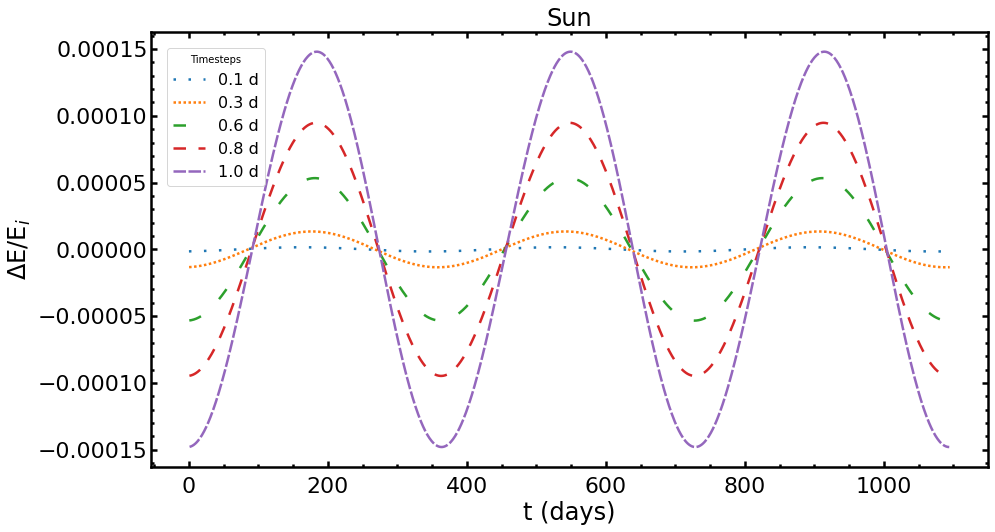

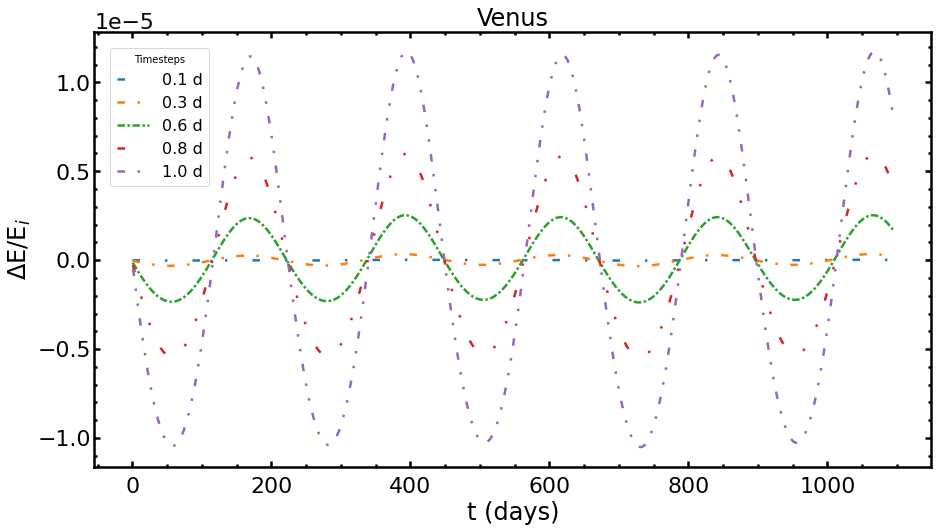

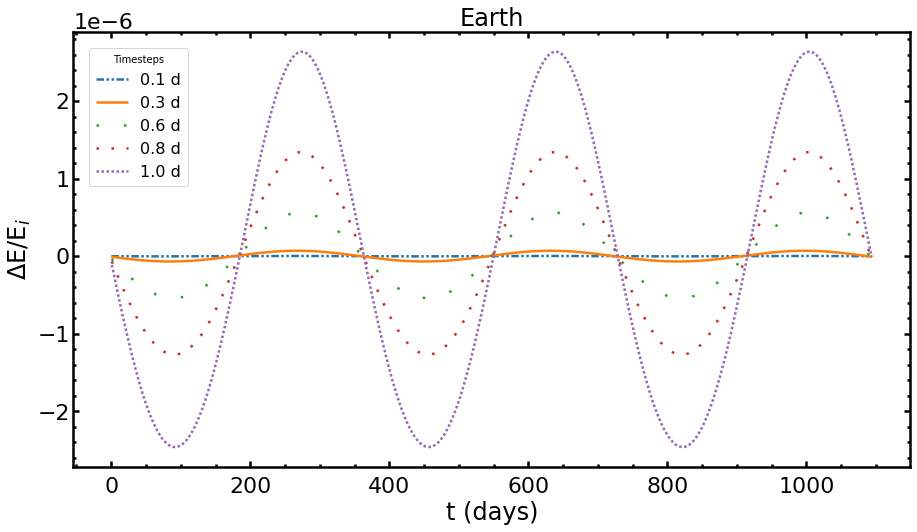

In [13]:
for i in range(len(bodies)):
    fig=plt.figure(figsize=(15,8))
    for n,delta_E in enumerate(delta_Es):
        t_range = t_ranges[n]
        t_range = [t.value for t in t_range]
        # delta_E_y = [k.value for k in delta_E[i]]
        delta_E_y = delta_E[i]
        line=next(linecycler)
        plt.plot(t_range,delta_E_y,linestyle=line,label=f'{delta_ts[n]}')
    plt.legend(title=f'Timesteps')
    plt.title(f'{list(bodies.items())[i][0]}')
    plt.xlabel('t (days)')
    plt.ylabel(r'$\Delta$E/E$_i$')
    plt.show()

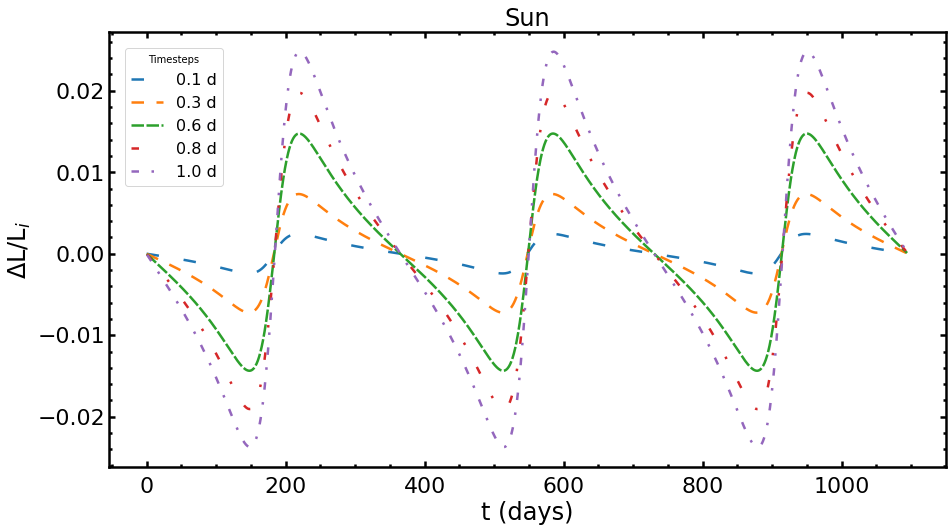

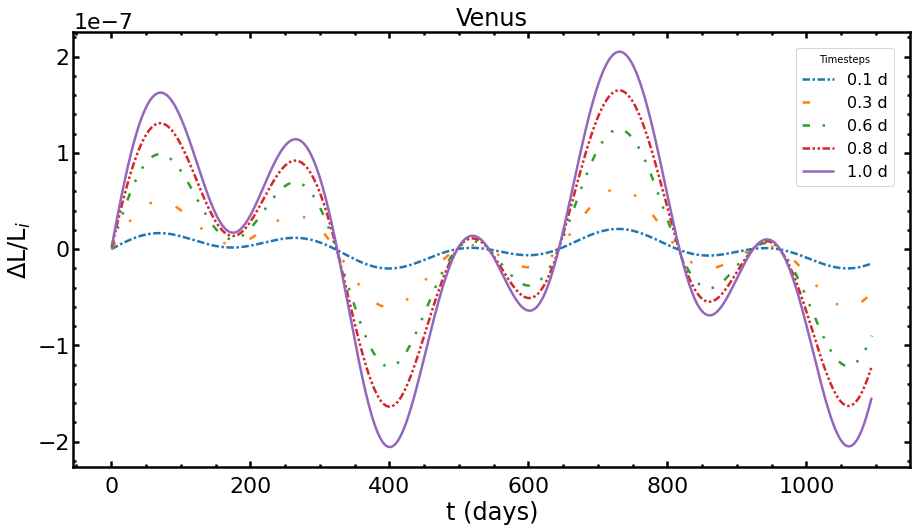

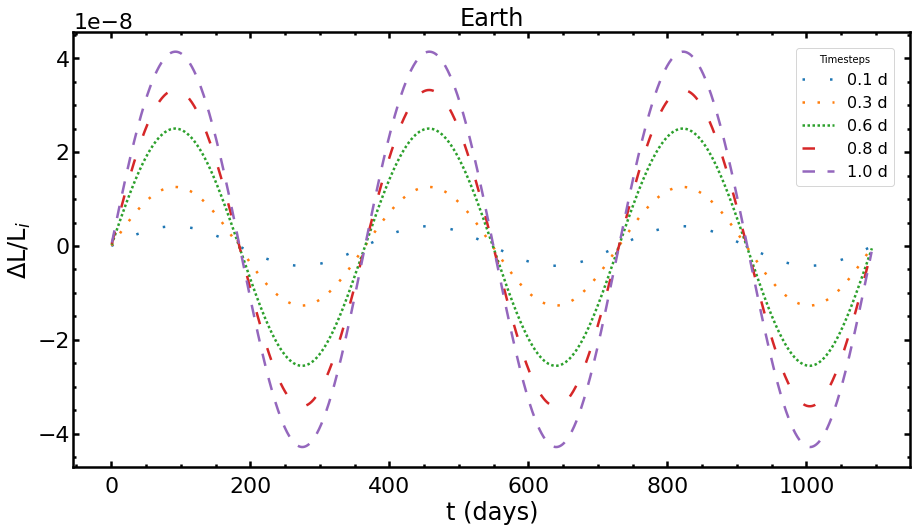

In [14]:
for i in range(len(bodies)):
    fig=plt.figure(figsize=(15,8))
    for n,delta_L in enumerate(delta_Ls):
        t_range = t_ranges[n]
        t_range = [t.value for t in t_range]
        # delta_L_y = [l.value for l in delta_L[i]]
        delta_L_y = delta_L[i]
        line=next(linecycler)
        plt.plot(t_range,delta_L_y,linestyle=line,label=f'{delta_ts[n]}')
    plt.legend(title=f'Timesteps')
    plt.title(f'{list(bodies.items())[i][0]}')
    plt.xlabel('t (days)')
    plt.ylabel(r'$\Delta$L/L$_i$')
    plt.show()